![Banner logo](https://raw.githubusercontent.com/CitrineInformatics/community-tools/master/templates/fig/citrine_banner_2.png "Banner logo")

## Exercises in Machine Learning

*Authors: Zach del Rosario (zdelrosario@citrine.io)*

The _primary_ purpose of this notebook is to help you *not get fooled by machine learning*! As Drew Conway notes, possessing hacking skills and substantive experience -- but having no math or statistics background -- puts one in the [danger zone](http://drewconway.com/zia/2013/3/26/the-data-science-venn-diagram). While we can't possibly cover *everything* you need in a single workshop, this exercise will highlight some of the challenges of doing machine learning well. 

Once we've "eaten our vegetables", we'll be ready to start using machine learning to study materials science problems. We'll use the [Agrawal et al. (2014) IMMI](https://citrination.com/datasets/150670/show_search?searchMatchOption=fuzzyMatch) dataset to study the relationship between alloy composition and fatigue strength.

In this exercise, you will:

* Use scikit-learn to fit regression models to data
* Use cross-validation to help avoid *underfitting* and *overfitting* of data
* Train a machine learning model to predict the fatigue strength of metal alloys
* Learn about additional topics for further study

Tips:

* This exercise will make heavy use of [scikit-learn](https://scikit-learn.org/stable/); you can find lots of useful info on the [documentation site](https://scikit-learn.org/stable/documentation.html).

In [1]:
# Setup
import numpy as np
import pandas as pd

# Model training tools
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_validate
from sklearn.metrics.scorer import make_scorer

# For jupyter-matplotlib compatibility
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

# Custom tools
from workshop_utils import formulas2df

# Agrawal data from previous exercise
filename_data = "./agrawal_data.csv"

# Helper functions
def nde(y_true, y_pred):
    """Non-dimensional Model Error
    """
    mse = mean_squared_error(y_true, y_pred)
    response_std = np.std(y_true)
    
    return np.sqrt(mse) / response_std

nde_score = make_scorer(nde)

def add_noise(function, sigma = 0.1, seed = 101):
    """Add noise to deterministic functions
    """
    def new_function(x):
        np.random.seed(seed)
        y = function(x)
        return y + sigma * np.random.normal(size = y.shape)
    
    return new_function

# Reference points for regression examples
X_ref = np.atleast_2d(np.linspace(-1, +1, num = 100)).T
# Reference models
fcn_1 = lambda x: (0.3 * x**2 + 1.0 * x + 2).flatten()
fcn_1_noisy = add_noise(fcn_1)
fcn_2 = lambda x: (-2.0 * x**3 + 0.4 * x**2 + 1.0 * x + 2).flatten()
fcn_2_noisy = add_noise(fcn_2, sigma = 0.2)

## Primer: The Key Ideas
First we'll cover some key ideas on simple functions. These are not 'real' data, but the simplicity of the examples will allow us to focus on concepts.

Here I generate some data from a simple polynomial.

In [2]:
## Ground-truth data; no noise
X_c = np.atleast_2d(np.linspace(-1, +1, num = 10)).T
Y_1 = fcn_1(X_c)

We will fit a simple [linear regression](https://en.wikipedia.org/wiki/Linear_regression) to these data. To do this, we'll use the implementation `LinearRegression()` from scikit-learn. To start, we'll assume that the data were generated from an underlying rule (a _model_) of the form

$$y = m x + b,$$

and attempt to _learn_ the slope $m$ and intercept $b$ by _minimizing_ the difference between the measured values `Y_1` and the predicted values `Y_1_linear_pred`.

### Q1: Fit a linear regression
Use the scikit-learn function `LinearRegression()` to fit a line to the data `X_c, Y_1`.

Note: You will have to [look up](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) the documentation for `LinearRegression()`!

nde = 0.158
(Should be nde = 0.158)


/Users/zdelrosario/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/base.py:485: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


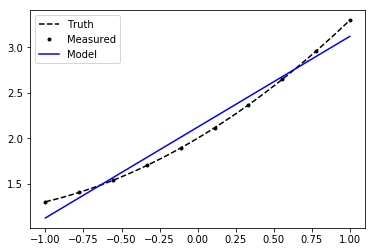

In [3]:
## TASK: Fit a line on X_c, Y_1
reg_1_linear = None # TODO: Fit a scikit learn regression with LinearRegression()
# solution-begin
reg_1_linear = LinearRegression().fit(X_c, Y_1)
# solution-end
## Predict using fitted model
Y_1_ref = fcn_1(X_ref)
Y_1_linear_pred = reg_1_linear.predict(np.atleast_2d(X_ref)) # Predict using model from above

## Compute mean-squared error
nde_1 = nde(Y_1_ref, Y_1_linear_pred)
print("nde = {0:4.3f}".format(nde_1))
print("(Should be nde = 0.158)")

## Plot results
plt.figure()
plt.plot(X_ref, Y_1_ref, 'k--', label = "Truth")
plt.plot(X_c, Y_1, 'k.', label = "Measured")
plt.plot(X_ref, Y_1_linear_pred, 'b-', label = "Model")
plt.legend(loc = 0)
plt.show()

### Model Flexibility and _Underfitting_
Note that we had to _assume_ a model-form in order to do the fitting. From the figure above, we can see that the model is close to the true values, but obviously lacks the curvature of the true data-generating process.

This phenomenon -- failing to capture behavior in the data -- is called _underfitting_. This leads to error in the model, which is quantified above using _non-dimensional error_ (NDE). To reduce this contribution to error, we need to make our model _more flexible_ -- one way to do this is to add additional _features_ for the model to fit. 

### Featurization
In this simple problem, we only have a single input $x$. However, we can generate additional _features_ on which to fit by considering additional _powers_ of $x$. For instance, we could fit a quadratic model

$$y = b x^0 + m_1 x^1 + m_2 x^2.$$

It is a _common misconception_ that linear regression _cannot fit nonlinear models_. Clearly the model above is nonlinear, but it is _linear in the features_ $[1, x^1, x^2]$. By providing the additional quadratic term, we give the model more flexibility to fit patterns in the data. Below, you will compute this quadratic featurization by using the `PolynomialFeatures()` function from scikit-learn.

### Q2: Build polynomial features
Use the scikit-learn function `PolynomialFeatures()` to build a matrix of values $[1, x^1, x^2]$.

Note: You'll probably need to look up the documentation for `PolynomialFeatures()`!

In [4]:
## TASK: Featurize the data
poly_2d = None  # TODO: Generate a transformation object using PolynomialFeatures()
X_quad = X_c    # TODO: Compute featurization to add quadratic term
# solution-begin
poly_2d = PolynomialFeatures(2)
X_quad = poly_2d.fit_transform(X_c)
# solution-end
print(X_quad)
print("(Should be)\n [Constant,    Linear,     Quadratic]")

[[ 1.         -1.          1.        ]
 [ 1.         -0.77777778  0.60493827]
 [ 1.         -0.55555556  0.30864198]
 [ 1.         -0.33333333  0.11111111]
 [ 1.         -0.11111111  0.01234568]
 [ 1.          0.11111111  0.01234568]
 [ 1.          0.33333333  0.11111111]
 [ 1.          0.55555556  0.30864198]
 [ 1.          0.77777778  0.60493827]
 [ 1.          1.          1.        ]]
(Should be)
 [Constant,    Linear,     Quadratic]


Note that this featurization gives rows of $[x^0, x^1, x^2]$, as we discussed above. Now we can use the featurized data to fit a quadratic model, and can use the same transform to evaluate the model on the reference points `X_ref`.

### Q3: Fit a quadratic regression
Use the transform `poly_2d` and featurized data `X_quad` to fit and evaluate a quadratic model.

nde = 0.000
(Should be nde = 0.000)


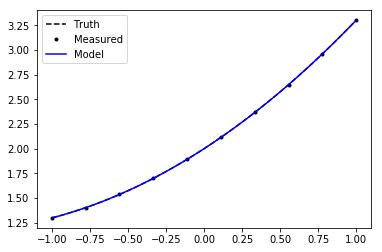

In [5]:
## TASK: Use your featurization to fit a new model
Y_1_quad_pred = Y_1_ref # TODO: Compute predictions
# solution-begin
reg_1_quad = LinearRegression().fit(X_quad, Y_1)
Y_1_quad_pred = reg_1_quad.predict(poly_2d.fit_transform(X_ref))
# solution-end
## Compute mean-squared error
nde_1_quad = nde(Y_1_ref, Y_1_quad_pred)
print("nde = {0:4.3f}".format(nde_1_quad))
print("(Should be nde = 0.000)")

## Plot results
plt.figure()
plt.plot(X_ref, Y_1_ref, 'k--', label = "Truth")
plt.plot(X_c, Y_1, 'k.', label = "Measured")
plt.plot(X_ref, Y_1_quad_pred, 'b-', label = "Model")
plt.legend(loc = 0)
plt.show()

Here we can see the model fits the data _perfectly_, which is corroborated by `nde = 0.000`. This _suggests_ that we have successfully discovered the _exact_ rule that generated these data, which in _this special case happens to be true_.

However, we will very rarely be able to fit the true function exactly. This is because real data tend to have _noise_, which corrupts the underlying function we are trying to learn.

### Noise and _Overfitting_
Below, I generate data from the same model, but add a little bit of noise.

In [6]:
## Noisy data
Y_1_noisy = fcn_1_noisy(X_c)

First, try fitting a quadratic to these new data, and inspect the fit.

### Q4: Fit a quadratic model to noisy data

nde = 0.139
(Should be nde = 0.139)


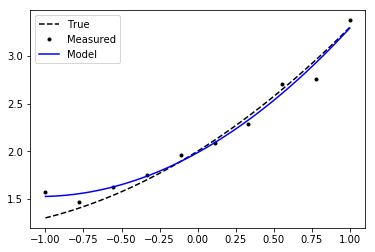

In [7]:
## TASK: Fit a model on X_1, Y_1_noisy
Y_1_noisy_pred = Y_1_ref # TODO: Compute predictions
# solution-begin
reg_1_noisy = LinearRegression().fit(X_quad, Y_1_noisy)
Y_1_noisy_pred = reg_1_noisy.predict(poly_2d.fit_transform(X_ref))
# solution-end
## Compute mean-squared error
nde_1_noisy = nde(Y_1_ref, Y_1_noisy_pred)
print("nde = {0:4.3f}".format(nde_1_noisy))
print("(Should be nde = 0.139)")

## Plot results
plt.figure()
plt.plot(X_ref, Y_1_ref, 'k--', label = "True")
plt.plot(X_c, Y_1_noisy, 'k.', label = "Measured")
plt.plot(X_ref, Y_1_noisy_pred, 'b-', label = "Model")
plt.legend(loc = 0)
plt.show()

Here we can see that the fit is no longer perfect, despite coming from the "same" model. This is also reflected in the finite NDE value. Since we already know that a quadratic can fit the underlying function perfectly, underfitting is not the issue here. Instead, the error is increased due to the noise in the data.

_However_, we have not yet seen a case of _overfitting_. To see that phenomenon, let's consider a slightly more complicated function.

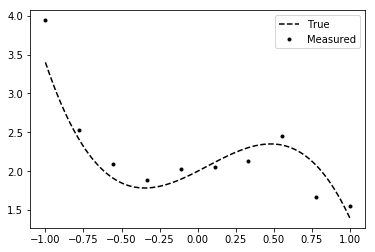

In [8]:
# Generate data from the true function
Y_2_ref = fcn_2(X_ref)
# Generate noisy data
Y_2_noisy = fcn_2_noisy(X_c)

plt.figure()
plt.plot(X_ref, Y_2_ref, 'k--', label = "True")
plt.plot(X_c, Y_2_noisy, 'k.', label = "Measured")
plt.legend(loc = 0)
plt.show()

Here we can see a somewhat complicated function that is quite corrupted by noise. Below, I'm going to fit a number of polynomial models of different orders. In practice, we would like to _make a decision_ about what polynomial order to use. A sensible choice would be to pick the order that minimizes the error -- let's see which model accomplishes this.

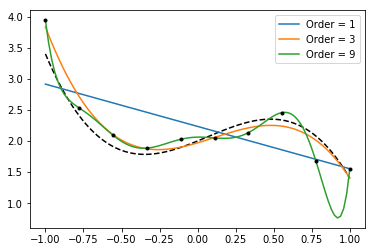

In [9]:
# Fit and predict on same data
def fit_poly(X, Y, order):
    poly = PolynomialFeatures(order)
    X_poly = poly.fit_transform(X)
    
    reg = LinearRegression().fit(X_poly, Y)
    
    return reg, poly

Ord_all = list(range(15))
Ord_plot = [1, 3, 9]
Y_pred_c = np.zeros((len(Ord_all), X_c.shape[0]))
Y_pred_ref = np.zeros((len(Ord_all), X_ref.shape[0]))
NDE_c = np.zeros(len(Ord_all))
NDE_ref = np.zeros(len(Ord_all))

plt.figure()
plt.plot(X_ref, Y_2_ref, 'k--')
for i in range(len(Ord_all)):
    # Fit model
    reg, poly = fit_poly(X_c, Y_2_noisy, Ord_all[i])
    # Predict on same data & on reference points
    Y_pred_c[i] = reg.predict(poly.fit_transform(X_c))
    Y_pred_ref[i] = reg.predict(poly.fit_transform(X_ref))
    # Compute error *on same data* -> estimated error
    NDE_c[i] = nde(Y_2_noisy, Y_pred_c[i])
    # Compute error on reference points -> 'true' error
    NDE_ref[i] = nde(Y_2_ref, Y_pred_ref[i])
    
    # Plot curve
    if Ord_all[i] in Ord_plot:
        plt.plot(X_ref, Y_pred_ref[i], label = "Order = {}".format(Ord_all[i]))
plt.plot(X_c, Y_2_noisy, 'k.')
plt.legend(loc = 0)
plt.show()    

Here I've selected just a few of the models to plot. We can see

* The `Order = 1` case is underfit, like we saw in the example above
* The `Order = 14` case curves tortuously to go through _every single point_; this is an example of _overfitting_
* The `Order = 3` case is not perfect, but fairly close to the true (dashed) curve. This is a well-fit model.

More generally, _overfitting_ is when the model fits to spurrious patterns in the data; essentially, we are fitting to noise, rather than signal. We would like to detect and avoid overfitting in practice! While we can see above some suspicious behavior based on the fitted curves, we might like a _quantitative_ way to compare models. We can do this with the NDE values, but there is a _subtle issue_ at play here.

Let's compare the `NDE` values `Estimated` on only the available (noisy) data, and the error computed using evaluations from the `True` (noiseless) function.

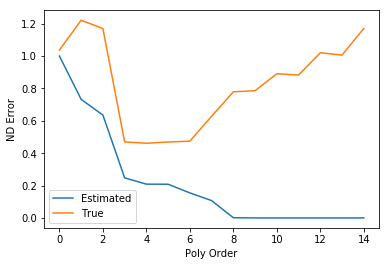

In [10]:
plt.figure()
plt.plot(Ord_all, NDE_c, label = 'Estimated')
plt.plot(Ord_all, NDE_ref, label = 'True')
plt.legend(loc = 0)
plt.xlabel('Poly Order')
plt.ylabel('ND Error')
plt.show()

Here we can see the `Estimated` and `True` error values _greatly diverge_. This is _highly problematic_ for two interrelated reasons:

1. In practice, we would only have access to the `Estimated` curve, as the `True` curve relies on data we do not have.
2. If we were to make a decision about `Poly Order` based on the `Estimated` curve, we would choose a much higher order than what would minimize the NDE in the `True` case.

The underlying reason for the poor error estimate here is that _we are using the same data to both train and test the model_. We can improve our estimates for the error through various techniques; below, we will use the technique of _cross-validation_.

### Avoiding Optimistic Estimates: Cross-Validation
[Cross-validation](https://en.wikipedia.org/wiki/Cross-validation_(statistics)) is a technique for estimating the error in a way that avoids the "optimism" we saw above. For the variant _k-fold cross-validation_, we split all our data into _folds_, and use these to build _training_ and _test_ sets. Generally:

* _Training_ data are used to fit a model
* _Test_ data are used to evaluate a model

![CV schematic](https://upload.wikimedia.org/wikipedia/commons/1/1c/K-fold_cross_validation_EN.jpg)

(Fabian Flock, via Wikimedia)

In each of our $k$ iterations, we _do not allow_ the model to see a test fold, and fit the model only on the remaining data. We then compute our chosen error metric on the test fold. This gives us a less optimistic estimate for the error.

This procedure is implemented in the scikit-learn function `cross_validate()`. Use this routine to estimate the NDE in the case where the polynomial order is `9`. You will have to choose a number of folds to run; while `5` to `10` is common, since we have so few data, you will need to use a smaller number of folds.

### Q5: K-fold Cross-Validation
Perform k-fold cross validation on the order `9` polynomial model using the scikit-learn function `cross_validate()`.

In [11]:
## TASK: Use cross_validate() on the 9th order model to estimate the NDE
## Hint, you can pass the helper function `nde_score` (defined above) to cross_validate()
# solution-begin
reg9, poly9 = fit_poly(X_c, Y_2_noisy, 9)
X_9 = poly9.fit_transform(X_c)

scores = cross_validate(
    reg9, X_9, Y_2_noisy,
    cv = 3,
    scoring = nde_score,
    return_train_score = True
)
# solution-end
scores

{'fit_time': array([0.00070214, 0.00056076, 0.00047207]),
 'score_time': array([0.00039792, 0.00031424, 0.00032997]),
 'test_score': array([17.71380909,  5.52330235, 25.01551704]),
 'train_score': array([9.80396622e-15, 1.03101715e-15, 1.79319959e-15])}

The `train_score` values are quite optimistic, while the `test_score` values are *abysmal*.

Below, I show results for performing k-fold cross validation across the same set of polynomial orders as above.

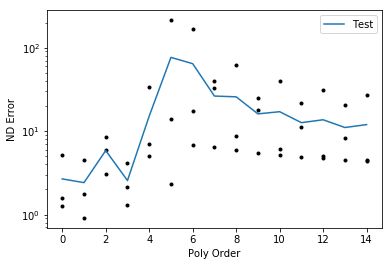

In [12]:
# task-begin
# REDACTED....
# task-end
# solution-begin
n_cv = 3
NDE_cv_test_all = np.zeros((len(Ord_all), n_cv))
NDE_cv_train_all = np.zeros((len(Ord_all), n_cv))

plt.figure()

for i in range(len(Ord_all)):
    # Fit model
    reg, poly = fit_poly(X_c, Y_2_noisy, Ord_all[i])
    # Cross-validate
    scores = cross_validate(
        reg, poly.fit_transform(X_c), Y_2_noisy,
        cv = n_cv,
        scoring = nde_score,
        return_train_score = True
    )
    NDE_cv_test_all[i] = scores['test_score']
    NDE_cv_train_all[i] = scores['train_score']
    # Plot all CV test instances
    plt.plot([Ord_all[i]] * n_cv, NDE_cv_test_all[i], 'k.')
NDE_cv_test = np.mean(NDE_cv_test_all, axis = 1)
NDE_cv_train = np.mean(NDE_cv_train_all, axis = 1)

plt.plot(Ord_all, NDE_cv_test, label = 'Test')
plt.legend(loc = 0)
plt.yscale('log')
plt.xlabel('Poly Order')
plt.ylabel('ND Error')
plt.show()
# solution-end

Here we can see that the NDE takes reasonable values for order at or below `3`. Beyond this point, the NDE explodes as models begin to overfit wildly. These cross-validated error metrics would be far more informative for making a decision about polynomial order.

Here we have just one tunable knob (polynomial order) that defines our model. More generally, these kinds of user-selected quantities are called [hyperparameters](https://en.wikipedia.org/wiki/Hyperparameter_(machine_learning)). Cross-validation and related techniques are key to _tuning hyperparameters_.

## Payoff: ML on Materials Data
Now that we have learned some (but not _all_!) concepts about training machine learning models, we are finally ready to apply ML to a materials problem.

### Q6: Load the Fatigue Strength data
Load the Agrawal fatigue strength data from the earlier exercise. Its filename is stored in the variable `filename_data`. Make sure to load the data to a Pandas DataFrame, and name it `df_data`.

In [13]:
## TASK: Load the Agrawal data from the file at filename_data
# solution-begin
df_data = pd.read_csv(filename_data)
# solution-end
df_data.head()

,Unnamed: 0,Sample Number,Area Proportion of Inclusions Occurring in Discontinuous Array,Quenching Media Temperature (for Carburization),Diffusion time,Fatigue Strength,Through Hardening Time,Cooling Rate for Tempering,Reduction Ratio (Ingot to Bar),Normalizing Temperature,Diffusion Temperature,Carburization Time,Cooling Rate for Through Hardening,Area Proportion of Inclusions Deformed by Plastic Work,Tempering Temperature,Area Proportion of Isolated Inclusions,Tempering Time,Carburization Temperature,Through Hardening Temperature,chemical_formula
0,0,228.0,0.0,30.0,0.0,451.0,30.0,24.0,530.0,870.0,30.0,0.0,8.0,0.02,550.0,0.01,60.0,30.0,845.0,Fe0.9759C0.004Mn0.0156Cu0.0005Si0.0022P0.00011...
1,1,193.0,0.0,30.0,0.0,631.0,30.0,24.0,510.0,870.0,30.0,0.0,8.0,0.04,550.0,0.03,60.0,30.0,855.0,Fe0.97088C0.004Mn0.0074Cu0.001Si0.0025P0.00014...
2,2,233.0,0.0,30.0,0.0,406.0,30.0,24.0,610.0,870.0,30.0,0.0,8.0,0.03,600.0,0.01,60.0,30.0,845.0,Fe0.97588C0.0038Mn0.0152Cu0.0007Si0.0027P0.000...
3,3,22.0,0.0,30.0,0.0,433.0,30.0,24.0,1740.0,865.0,30.0,0.0,24.0,0.10,550.0,0.00,60.0,30.0,865.0,Fe0.98575C0.0037Mn0.0072Cu0.0002Si0.0024P0.000...
4,4,240.0,0.0,30.0,0.0,385.0,30.0,24.0,610.0,870.0,30.0,0.0,8.0,0.03,650.0,0.01,60.0,30.0,845.0,Fe0.97588C0.0038Mn0.0152Cu0.0007Si0.0027P0.000...


### Simple featurization
Alloy composition is encoded in a string in the column `chemical_formula`.

In [18]:
df_data[['chemical_formula']].head()

,chemical_formula
0,Fe0.9759C0.004Mn0.0156Cu0.0005Si0.0022P0.00011...
1,Fe0.97088C0.004Mn0.0074Cu0.001Si0.0025P0.00014...
2,Fe0.97588C0.0038Mn0.0152Cu0.0007Si0.0027P0.000...
3,Fe0.98575C0.0037Mn0.0072Cu0.0002Si0.0024P0.000...
4,Fe0.97588C0.0038Mn0.0152Cu0.0007Si0.0027P0.000...


Fitting a linear regression _directly_ to this _string representation_ is not feasible -- these are not continuous values! Instead, we will _featurize_ the chemical formulas by representing each element fraction as a separate column.

Note that doing this _programmatically_ is a bit tricky (it requires [regular expressions](https://en.wikipedia.org/wiki/Regular_expression)) -- I've written a simple parser to do this in a single function call. Feel free to inspect the code in `workshop_utils.py` if you'd like to see how this works! 

In [14]:
df_composition = formulas2df(df_data['chemical_formula'])
X_compositions = df_composition.values
Y_fatigue = df_data['Fatigue Strength']

df_composition.head()

,C,Cr,Cu,Fe,Mn,Mo,Ni,P,S,Si
0,0.0040,0.0009,0.0005,0.97590,0.0156,0.0000,0.0006,0.00011,0.00019,0.0022
1,0.0040,0.0096,0.0010,0.97088,0.0074,0.0018,0.0024,0.00014,0.00028,0.0025
2,0.0038,0.0013,0.0007,0.97588,0.0152,0.0000,0.0003,0.00012,0.00000,0.0027
3,0.0037,0.0002,0.0002,0.98575,0.0072,0.0000,0.0002,0.00015,0.00020,0.0024
4,0.0038,0.0013,0.0007,0.97588,0.0152,0.0000,0.0003,0.00012,0.00000,0.0027


In [15]:
X_compositions.shape

(437, 10)

Now we have ten physical features on which to fit our model.

### Q7: Fit a linear model on alloy composition
Cross-validate across the polynomial order and determine the optimal order for the model.

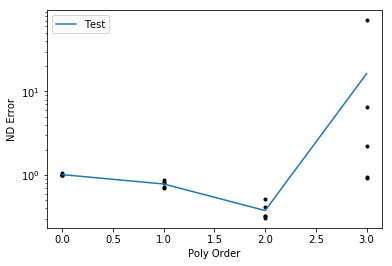

In [16]:
## TASK: Write your own code to sweep over polynomial orders, and fit a linear model to the 
## Agrawal fatigue strength data given in X_compositions and Y_fatigue. Feel free to use
## any of the code above in writing your machine learning code.
# solution-begin
Ord_all = [0,1,2,3]
n_cv = 5
NDE_cv_test_all = np.zeros((len(Ord_all), n_cv))
NDE_cv_train_all = np.zeros((len(Ord_all), n_cv))

plt.figure()

for i in range(len(Ord_all)):
    # Fit model
    reg, poly = fit_poly(X_compositions, Y_fatigue, Ord_all[i])
    # Cross-validate
    scores = cross_validate(
        reg, poly.fit_transform(X_compositions), Y_fatigue,
        cv = n_cv,
        scoring = nde_score,
        return_train_score = True
    )
    NDE_cv_test_all[i] = scores['test_score']
    NDE_cv_train_all[i] = scores['train_score']
    # Plot all CV test instances
    plt.plot([Ord_all[i]] * n_cv, NDE_cv_test_all[i], 'k.')
NDE_cv_test = np.mean(NDE_cv_test_all, axis = 1)
NDE_cv_train = np.mean(NDE_cv_train_all, axis = 1)

plt.plot(Ord_all, NDE_cv_test, label = 'Test')
plt.legend(loc = 0)
plt.yscale('log')
plt.xlabel('Poly Order')
plt.ylabel('ND Error')
plt.show()
# solution-end

In [17]:
ind_min = np.argmin(NDE_cv_test)
print("ord_min = {}".format(Ord_all[ind_min]))
print("NDE_min = {}".format(NDE_cv_test[ind_min]))

ord_min = 2
NDE_min = 0.3762770089971318


### Going Further
As mentioned above, we cannot possibly cover every topic relevant to machine learning in this workshop. The following are some concepts you may choose to study as a follow-up to this exercise.

__Process Characteristics__: Above we have only used the chemical compositions to predict fatigue strength; however, we also have processing characterisic data available. You can use your Pandas skills to combine compositions and processing data into a single array `X_both`, and use all these data to fit a model.

__Advanced featurization with Matminer__: [Matminer](https://hackingmaterials.lbl.gov/matminer/) is a set of tools for data-mining on chemicals data. Their library provides tools to produce _descriptors_ (features) based on chemical compositions.

__Feature Selection__: One 'hyperparameter' we have not explicitly mentioned is _the choice of features_ for the model. While additional features do provide more information, they also increase the number of parameters (internal coefficients) the model needs to learn. This can lead to overfitting in the same way we saw above. To help combat this issue, data scientists will perform [feature selection](https://en.wikipedia.org/wiki/Feature_selection) to choose the "most informative" features from a set, which can improve model generalizability.

__Different Models__: We considered only simple polynomial models in this tutorial, but there exist many other model types. Some highlights:

* [Gaussian processes](https://en.wikipedia.org/wiki/Gaussian_process)
* [Random forests](https://en.wikipedia.org/wiki/Random_forest)
* [Neural networks](https://en.wikipedia.org/wiki/Artificial_neural_network)

### Using Models
In the final part of the workshop, we will discuss how to _use_ these machine learning models to do useful work. Stay tuned!
